This is a companion notebook for the book [Deep Learning with Python, Third Edition](https://www.manning.com/books/deep-learning-with-python-third-edition). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

The book's contents are available online at [deeplearningwithpython.io](https://deeplearningwithpython.io).

In [1]:
# Ajout DC
# La ligne suivante est inutile dans Google Colab
# !pip install keras keras-hub --upgrade -q

In [2]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [3]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Text classification

### A brief history of natural language processing

### Preparing text data

In [4]:
import regex as re

def split_chars(text):
    return re.findall(r".", text)

In [5]:
chars = split_chars("The quick brown fox jumped over the lazy dog.")
chars[:12]

['T', 'h', 'e', ' ', 'q', 'u', 'i', 'c', 'k', ' ', 'b', 'r']

In [6]:
def split_words(text):
    return re.findall(r"[\w]+|[.,!?;]", text)

In [7]:
split_words("The quick brown fox jumped over the dog.")

['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'dog', '.']

In [8]:
vocabulary = {
    "[UNK]": 0,
    "the": 1,
    "quick": 2,
    "brown": 3,
    "fox": 4,
    "jumped": 5,
    "over": 6,
    "dog": 7,
    ".": 8,
}
words = split_words("The quick brown fox jumped over the lazy dog.")
indices = [vocabulary.get(word, 0) for word in words]

#### Character and word tokenization

In [9]:
class CharTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def split(self, inputs):
        return re.findall(r".", inputs)

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [10]:
import collections

def compute_char_vocabulary(inputs, max_size):
    char_counts = collections.Counter()
    for x in inputs:
        x = x.lower()
        tokens = re.findall(r".", x)
        char_counts.update(tokens)
    vocabulary = ["[UNK]"]
    most_common = char_counts.most_common(max_size - len(vocabulary))
    for token, count in most_common:
        vocabulary.append(token)
    return dict((token, i) for i, token in enumerate(vocabulary))

In [11]:
class WordTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def split(self, inputs):
        return re.findall(r"[\w]+|[.,!?;]", inputs)

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [12]:
def compute_word_vocabulary(inputs, max_size):
    word_counts = collections.Counter()
    for x in inputs:
        x = x.lower()
        tokens = re.findall(r"[\w]+|[.,!?;]", x)
        word_counts.update(tokens)
    vocabulary = ["[UNK]"]
    most_common = word_counts.most_common(max_size - len(vocabulary))
    for token, count in most_common:
        vocabulary.append(token)
    return dict((token, i) for i, token in enumerate(vocabulary))

In [13]:
import keras

filename = keras.utils.get_file(
    origin="https://www.gutenberg.org/files/2701/old/moby10b.txt",
)
moby_dick = list(open(filename, "r"))

vocabulary = compute_char_vocabulary(moby_dick, max_size=100)
char_tokenizer = CharTokenizer(vocabulary)

1256167/1256167 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
print("Vocabulary length:", len(vocabulary))

Vocabulary length: 64


In [15]:
print("Vocabulary start:", list(vocabulary.keys())[:10])

Vocabulary start: ['[UNK]', ' ', 'e', 't', 'a', 'o', 'n', 'i', 's', 'h']


In [16]:
print("Vocabulary end:", list(vocabulary.keys())[-10:])

Vocabulary end: ['@', '$', '%', '#', '=', '~', '&', '+', '<', '>']


In [17]:
print("Line length:", len(char_tokenizer(
   "Call me Ishmael. Some years ago--never mind how long precisely."
)))

Line length: 63


In [18]:
vocabulary = compute_word_vocabulary(moby_dick, max_size=2_000)
word_tokenizer = WordTokenizer(vocabulary)

In [19]:
print("Vocabulary length:", len(vocabulary))

Vocabulary length: 2000


In [20]:
print("Vocabulary start:", list(vocabulary.keys())[:5])

Vocabulary start: ['[UNK]', ',', 'the', '.', 'of']


In [21]:
print("Vocabulary end:", list(vocabulary.keys())[-5:])

Vocabulary end: ['tambourine', 'subtle', 'perseus', 'elevated', 'repose']


In [22]:
print("Line length:", len(word_tokenizer(
   "Call me Ishmael. Some years ago--never mind how long precisely."
)))

Line length: 13


#### Subword tokenization

In [23]:
data = [
    "the quick brown fox",
    "the slow brown fox",
    "the quick brown foxhound",
]

In [24]:
def count_and_split_words(data):
    counts = collections.Counter()
    for line in data:
        line = line.lower()
        for word in re.findall(r"[\w]+|[.,!?;]", line):
            chars = re.findall(r".", word)
            split_word = " ".join(chars)
            counts[split_word] += 1
    return dict(counts)

counts = count_and_split_words(data)

In [25]:
counts

{'t h e': 3,
 'q u i c k': 2,
 'b r o w n': 3,
 'f o x': 2,
 's l o w': 1,
 'f o x h o u n d': 1}

In [26]:
def count_pairs(counts):
    pairs = collections.Counter()
    for word, freq in counts.items():
        symbols = word.split()
        for pair in zip(symbols[:-1], symbols[1:]):
            pairs[pair] += freq
    return pairs

def merge_pair(counts, first, second):
    split = re.compile(f"(?<!\S){first} {second}(?!\S)")
    merged = f"{first}{second}"
    return {split.sub(merged, word): count for word, count in counts.items()}

for i in range(10):
    pairs = count_pairs(counts)
    first, second = max(pairs, key=pairs.get)
    counts = merge_pair(counts, first, second)
    print(list(counts.keys()))

['t h e', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['th e', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'br ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brown', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brown', 'fo x', 's l ow', 'fo x h o u n d']
['the', 'q u i c k', 'brown', 'fox', 's l ow', 'fox h o u n d']
['the', 'qu i c k', 'brown', 'fox', 's l ow', 'fox h o u n d']
['the', 'qui c k', 'brown', 'fox', 's l ow', 'fox h o u n d']


<>:10: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\S'
<>:10: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-2139356449.py:10: SyntaxWarning: invalid escape sequence '\S'
  split = re.compile(f"(?<!\S){first} {second}(?!\S)")
/tmp/ipython-input-2139356449.py:10: SyntaxWarning: invalid escape sequence '\S'
  split = re.compile(f"(?<!\S){first} {second}(?!\S)")


In [27]:
def compute_sub_word_vocabulary(dataset, vocab_size):
    counts = count_and_split_words(dataset)

    char_counts = collections.Counter()
    for word in counts:
        for char in word.split():
            char_counts[char] += counts[word]
    most_common = char_counts.most_common()
    vocab = ["[UNK]"] + [char for char, freq in most_common]
    merges = []

    while len(vocab) < vocab_size:
        pairs = count_pairs(counts)
        if not pairs:
            break
        first, second = max(pairs, key=pairs.get)
        counts = merge_pair(counts, first, second)
        vocab.append(f"{first}{second}")
        merges.append(f"{first} {second}")

    vocab = dict((token, index) for index, token in enumerate(vocab))
    merges = dict((token, rank) for rank, token in enumerate(merges))
    return vocab, merges

In [28]:
class SubWordTokenizer:
    def __init__(self, vocabulary, merges):
        self.vocabulary = vocabulary
        self.merges = merges
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def bpe_merge(self, word):
        while True:
            pairs = re.findall(r"(?<!\S)\S+ \S+(?!\S)", word, overlapped=True)
            if not pairs:
                break
            best = min(pairs, key=lambda pair: self.merges.get(pair, 1e9))
            if best not in self.merges:
                break
            first, second = best.split()
            split = re.compile(f"(?<!\S){first} {second}(?!\S)")
            merged = f"{first}{second}"
            word = split.sub(merged, word)
        return word

    def split(self, inputs):
        tokens = []
        for word in re.findall(r"[\w]+|[.,!?;]", inputs):
            word = " ".join(re.findall(r".", word))
            word = self.bpe_merge(word)
            tokens.extend(word.split())
        return tokens

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

<>:19: SyntaxWarning: invalid escape sequence '\S'
<>:19: SyntaxWarning: invalid escape sequence '\S'
<>:19: SyntaxWarning: invalid escape sequence '\S'
<>:19: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-759452212.py:19: SyntaxWarning: invalid escape sequence '\S'
  split = re.compile(f"(?<!\S){first} {second}(?!\S)")
/tmp/ipython-input-759452212.py:19: SyntaxWarning: invalid escape sequence '\S'
  split = re.compile(f"(?<!\S){first} {second}(?!\S)")


In [29]:
vocabulary, merges = compute_sub_word_vocabulary(moby_dick, 2_000)
sub_word_tokenizer = SubWordTokenizer(vocabulary, merges)

In [30]:
print("Vocabulary length:", len(vocabulary))

Vocabulary length: 2000


In [31]:
print("Vocabulary start:", list(vocabulary.keys())[:10])

Vocabulary start: ['[UNK]', 'e', 't', 'a', 'o', 'n', 'i', 's', 'h', 'r']


In [32]:
print("Vocabulary end:", list(vocabulary.keys())[-7:])

Vocabulary end: ['bright', 'pilot', 'sco', 'ben', 'dem', 'gale', 'ilo']


In [33]:
print("Line length:", len(sub_word_tokenizer(
   "Call me Ishmael. Some years ago--never mind how long precisely."
)))

Line length: 16


### Sets vs. sequences

#### Loading the IMDb classification dataset

In [34]:
import os, pathlib, shutil, random

zip_path = keras.utils.get_file(
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    fname="imdb",
    extract=True,
)

imdb_extract_dir = pathlib.Path(zip_path) / "aclImdb"

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [35]:
for path in imdb_extract_dir.glob("*/*"):
    if path.is_dir():
        print(path)

/root/.keras/datasets/imdb/aclImdb/train/unsup
/root/.keras/datasets/imdb/aclImdb/train/neg
/root/.keras/datasets/imdb/aclImdb/train/pos
/root/.keras/datasets/imdb/aclImdb/test/neg
/root/.keras/datasets/imdb/aclImdb/test/pos


In [36]:
print(open(imdb_extract_dir / "train" / "pos" / "4077_10.txt", "r").read())

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy


In [37]:
train_dir = pathlib.Path("imdb_train")
test_dir = pathlib.Path("imdb_test")
val_dir = pathlib.Path("imdb_val")

shutil.copytree(imdb_extract_dir / "test", test_dir)

val_percentage = 0.2
for category in ("neg", "pos"):
    src_dir = imdb_extract_dir / "train" / category
    src_files = os.listdir(src_dir)
    random.Random(1337).shuffle(src_files)
    num_val_samples = int(len(src_files) * val_percentage)

    os.makedirs(val_dir / category)
    for file in src_files[:num_val_samples]:
        shutil.copy(src_dir / file, val_dir / category / file)
    os.makedirs(train_dir / category)
    for file in src_files[num_val_samples:]:
        shutil.copy(src_dir / file, train_dir / category / file)

In [38]:
from keras.utils import text_dataset_from_directory

batch_size = 32
train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = text_dataset_from_directory(val_dir, batch_size=batch_size)
test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


### Set models

#### Training a bag-of-words model

In [39]:
from keras import layers

max_tokens = 20_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="multi_hot",
)
train_ds_no_labels = train_ds.map(lambda x, y: x)
text_vectorization.adapt(train_ds_no_labels)

bag_of_words_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [40]:
x, y = next(bag_of_words_train_ds.as_numpy_iterator())
x.shape

(32, 20000)

In [41]:
y.shape

(32,)

In [42]:
def build_linear_classifier(max_tokens, name):
    inputs = keras.Input(shape=(max_tokens,))
    outputs = layers.Dense(1, activation="sigmoid")(inputs)
    model = keras.Model(inputs, outputs, name=name)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = build_linear_classifier(max_tokens, "bag_of_words_classifier")

In [43]:
model.summary(line_length=80)

Model: "bag_of_words_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)          │ (None, 20000)            │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense (Dense)                     │ (None, 1)                │        20,001 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 20,001 (78.13 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
    patience=2,
)
history = model.fit(
    bag_of_words_train_ds,
    validation_data=bag_of_words_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7932 - loss: 0.5431 - val_accuracy: 0.8748 - val_loss: 0.3639
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9027 - loss: 0.3092 - val_accuracy: 0.8868 - val_loss: 0.3117
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9254 - loss: 0.2437 - val_accuracy: 0.8906 - val_loss: 0.2915
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9382 - loss: 0.2062 - val_accuracy: 0.8928 - val_loss: 0.2807
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9471 - loss: 0.1801 - val_accuracy: 0.8932 - val_loss: 0.2765
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9576 - loss: 0.1585 - val_accuracy: 0.8936 - val_loss: 0.2732
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9632 - loss: 0.1418 - val_accuracy: 0.8918 - val_loss: 0.2736
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9690 - loss: 0.1271 - val_accuracy: 0.

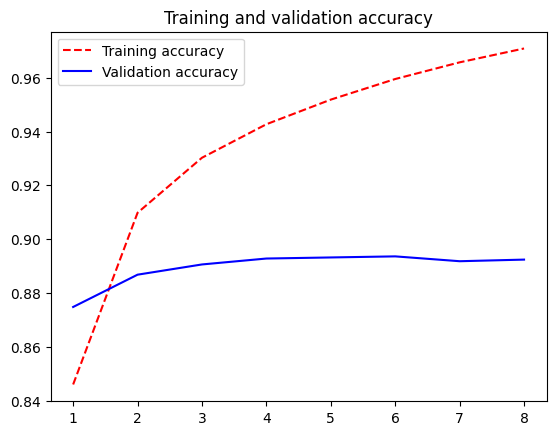

In [45]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [46]:
test_loss, test_acc = model.evaluate(bag_of_words_test_ds)
test_acc

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8861 - loss: 0.2814


0.8858399987220764

#### Training a bigram model

In [47]:
max_tokens = 30_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="multi_hot",
    ngrams=2,
)
text_vectorization.adapt(train_ds_no_labels)

bigram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bigram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bigram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [48]:
x, y = next(bigram_train_ds.as_numpy_iterator())
x.shape

(32, 30000)

In [49]:
text_vectorization.get_vocabulary()[100:108]

[np.str_('how'),
 np.str_('most'),
 np.str_('him'),
 np.str_('it was'),
 np.str_('dont'),
 np.str_('for the'),
 np.str_('one of'),
 np.str_('then')]

In [50]:
model = build_linear_classifier(max_tokens, "bigram_classifier")
model.fit(
    bigram_train_ds,
    validation_data=bigram_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8165 - loss: 0.4948 - val_accuracy: 0.8864 - val_loss: 0.3112
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9306 - loss: 0.2354 - val_accuracy: 0.8984 - val_loss: 0.2700
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9550 - loss: 0.1716 - val_accuracy: 0.9000 - val_loss: 0.2564
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9727 - loss: 0.1320 - val_accuracy: 0.8994 - val_loss: 0.2509
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9826 - loss: 0.1047 - val_accuracy: 0.9004 - val_loss: 0.2501
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9884 - loss: 0.0841 - val_accuracy: 0.8996 - val_loss: 0.2529
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9931 - loss: 0.0688 - val_accuracy: 0.8978 - val_loss: 0.2558


In [51]:
test_loss, test_acc = model.evaluate(bigram_test_ds)
test_acc

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9011 - loss: 0.2497


0.901639997959137

### Sequence models

In [52]:
max_length = 600
max_tokens = 30_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(train_ds_no_labels)

sequence_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
sequence_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
sequence_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [53]:
x, y = next(sequence_test_ds.as_numpy_iterator())
x.shape

(32, 600)

In [54]:
x

array([[  72, 6515,   46, ...,    0,    0,    0],
       [  10,  285,   11, ...,    0,    0,    0],
       [  10,  237,   22, ...,    0,    0,    0],
       ...,
       [  10,  497, 4476, ...,    0,    0,    0],
       [   1,    7,    3, ...,    0,    0,    0],
       [  30,   39,  284, ...,  115,  152,  162]])

#### Training a recurrent model

In [55]:
from keras import ops

class OneHotEncoding(keras.Layer):
    def __init__(self, depth, **kwargs):
        super().__init__(**kwargs)
        self.depth = depth

    def call(self, inputs):
        flat_inputs = ops.reshape(ops.cast(inputs, "int"), [-1])
        one_hot_vectors = ops.eye(self.depth)
        outputs = ops.take(one_hot_vectors, flat_inputs, axis=0)
        return ops.reshape(outputs, ops.shape(inputs) + (self.depth,))

one_hot_encoding = OneHotEncoding(max_tokens)

In [56]:
x, y = next(sequence_train_ds.as_numpy_iterator())
one_hot_encoding(x).shape

(32, 600, 30000)

In [57]:
hidden_dim = 64
inputs = keras.Input(shape=(max_length,), dtype="int32")
x = one_hot_encoding(inputs)
x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="lstm_with_one_hot")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [58]:
model.summary(line_length=80)

Model: "lstm_with_one_hot"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)        │ (None, 600)              │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ one_hot_encoding (OneHotEncoding) │ (None, 600, 30000)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)     │ (None, 128)              │    15,393,280 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout (Dropout)                 │ (None, 128)              │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_2 (Dense)                   │ (None, 1)                │           129 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 15,393,409 (58.72 MB)

 Trainable params: 15,393,409 (58.72 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# ⚠️NOTE⚠️: The following fit call will error on a T4 GPU on the TensorFlow
# backend due to a bug in TensorFlow. If you the follow cell errors out,
# do one of the following:
# - Skip the following two cells.
# - Switch to the Jax or Torch backend and re-run this notebook.
# - Change the GPU type in your runtime (requires Colab Pro as of this writing).

In [60]:
model.fit(
    sequence_train_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 156s 242ms/step - accuracy: 0.6557 - loss: 0.6090 - val_accuracy: 0.8550 - val_loss: 0.3733
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 235ms/step - accuracy: 0.8689 - loss: 0.3408 - val_accuracy: 0.8780 - val_loss: 0.3044
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 235ms/step - accuracy: 0.9214 - loss: 0.2276 - val_accuracy: 0.8608 - val_loss: 0.3443
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 235ms/step - accuracy: 0.9209 - loss: 0.2207 - val_accuracy: 0.8710 - val_loss: 0.3683


In [61]:
test_loss, test_acc = model.evaluate(sequence_test_ds)
test_acc

782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 66ms/step - accuracy: 0.8536 - loss: 0.3435


0.8513199687004089

#### Understanding word embeddings

#### Using a word embedding

In [62]:
hidden_dim = 64
inputs = keras.Input(shape=(max_length,), dtype="int32")
x = keras.layers.Embedding(
    input_dim=max_tokens,
    output_dim=hidden_dim,
    mask_zero=True,
)(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(hidden_dim))(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="lstm_with_embedding")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [63]:
model.summary(line_length=80)

Model: "lstm_with_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)          ┃ Output Shape      ┃     Param # ┃ Connected to       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3         │ (None, 600)       │           0 │ -                  │
│ (InputLayer)          │                   │             │                    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ embedding (Embedding) │ (None, 600, 64)   │   1,920,000 │ input_layer_3[0][… │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ not_equal (NotEqual)  │ (None, 600)       │           0 │ input_layer_3[0][… │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ bidirectional_1       │ (None, 128)       │      66,048 │ embedding[0][0],   │
│ (Bidirectional)       │                   │             │ not_equal[0][0]    │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ dropout_1 (Dropout)   │ (None, 128)       │           0 │ bidirectional_1[0… │
├───────────────────────┼───────────────────┼─────────────┼────────────────────┤
│ dense_3 (Dense)       │ (None, 1)         │         129 │ dropout_1[0][0]    │
└───────────────────────┴───────────────────┴─────────────┴────────────────────┘

 Total params: 1,986,177 (7.58 MB)

 Trainable params: 1,986,177 (7.58 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model.fit(
    sequence_train_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)
test_loss, test_acc = model.evaluate(sequence_test_ds)
test_acc

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 68s 104ms/step - accuracy: 0.6940 - loss: 0.5627 - val_accuracy: 0.8790 - val_loss: 0.2992
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 97ms/step - accuracy: 0.9132 - loss: 0.2204 - val_accuracy: 0.8568 - val_loss: 0.4121
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 97ms/step - accuracy: 0.9530 - loss: 0.1335 - val_accuracy: 0.8730 - val_loss: 0.4403
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.8662 - loss: 0.3158


0.8649199604988098

#### Pretraining a word embedding

In [65]:
imdb_vocabulary = text_vectorization.get_vocabulary()
tokenize_no_padding = keras.layers.TextVectorization(
    vocabulary=imdb_vocabulary,
    split="whitespace",
    output_mode="int",
)

In [66]:
import tensorflow as tf

context_size = 4
window_size = 9

def window_data(token_ids):
    num_windows = tf.maximum(tf.size(token_ids) - context_size * 2, 0)
    windows = tf.range(window_size)[None, :]
    windows = windows + tf.range(num_windows)[:, None]
    windowed_tokens = tf.gather(token_ids, windows)
    return tf.data.Dataset.from_tensor_slices(windowed_tokens)

def split_label(window):
    left = window[:context_size]
    right = window[context_size + 1 :]
    bag = tf.concat((left, right), axis=0)
    label = window[4]
    return bag, label

dataset = keras.utils.text_dataset_from_directory(
    imdb_extract_dir / "train", batch_size=None
)
dataset = dataset.map(lambda x, y: x, num_parallel_calls=8)
dataset = dataset.map(tokenize_no_padding, num_parallel_calls=8)
dataset = dataset.interleave(window_data, cycle_length=8, num_parallel_calls=8)
dataset = dataset.map(split_label, num_parallel_calls=8)

Found 75000 files belonging to 3 classes.


In [67]:
hidden_dim = 64
inputs = keras.Input(shape=(2 * context_size,))
cbow_embedding = layers.Embedding(
    max_tokens,
    hidden_dim,
)
x = cbow_embedding(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(max_tokens, activation="sigmoid")(x)
cbow_model = keras.Model(inputs, outputs)
cbow_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [68]:
cbow_model.summary(line_length=80)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)        │ (None, 8)                │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ embedding_1 (Embedding)           │ (None, 8, 64)            │     1,920,000 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ global_average_pooling1d          │ (None, 64)               │             0 │
│ (GlobalAveragePooling1D)          │                          │               │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_4 (Dense)                   │ (None, 30000)            │     1,950,000 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 3,870,000 (14.76 MB)

 Trainable params: 3,870,000 (14.76 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
dataset = dataset.batch(1024).cache()
cbow_model.fit(dataset, epochs=4)

Epoch 1/4
16503/16503 ━━━━━━━━━━━━━━━━━━━━ 249s 15ms/step - loss: 7.0594 - sparse_categorical_accuracy: 0.0326
Epoch 2/4


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


16503/16503 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - loss: 5.9906 - sparse_categorical_accuracy: 0.1114
Epoch 3/4
16503/16503 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - loss: 5.7913 - sparse_categorical_accuracy: 0.1247
Epoch 4/4
16503/16503 ━━━━━━━━━━━━━━━━━━━━ 22s 1ms/step - loss: 5.7006 - sparse_categorical_accuracy: 0.1281


#### Using the pretrained embedding for classification

In [70]:
inputs = keras.Input(shape=(max_length,))
lstm_embedding = layers.Embedding(
    input_dim=max_tokens,
    output_dim=hidden_dim,
    mask_zero=True,
)
x = lstm_embedding(inputs)
x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="lstm_with_cbow")

In [71]:
lstm_embedding.embeddings.assign(cbow_embedding.embeddings)

Array([[ 0.00793881, -0.0092621 ,  0.03984071, ..., -0.03311696,
        -0.04291171,  0.03008353],
       [-0.6658986 ,  0.19451499, -0.6036362 , ...,  0.22227241,
        -0.8623522 ,  0.22057635],
       [ 0.12943392, -0.4482007 ,  1.3054798 , ..., -1.4870726 ,
        -0.21043979,  0.09972168],
       ...,
       [-0.11027386,  0.11554745, -0.25490904, ...,  0.21028955,
        -0.1257532 , -0.00733972],
       [-0.7526603 , -0.11532738, -0.6674207 , ...,  0.00527173,
        -0.1978804 ,  0.2609984 ],
       [-0.6574629 ,  0.31509724,  0.34297076, ...,  0.19363236,
        -0.5893816 , -0.06322811]], dtype=float32)

In [72]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    sequence_train_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 103ms/step - accuracy: 0.6815 - loss: 0.5712 - val_accuracy: 0.8290 - val_loss: 0.3761
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 63s 97ms/step - accuracy: 0.8316 - loss: 0.3766 - val_accuracy: 0.8664 - val_loss: 0.3278
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 97ms/step - accuracy: 0.8774 - loss: 0.2881 - val_accuracy: 0.8874 - val_loss: 0.2975
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 97ms/step - accuracy: 0.9127 - loss: 0.2180 - val_accuracy: 0.8728 - val_loss: 0.3575
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 97ms/step - accuracy: 0.9393 - loss: 0.1579 - val_accuracy: 0.8934 - val_loss: 0.3035


In [73]:
test_loss, test_acc = model.evaluate(sequence_test_ds)
test_acc

782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.8858 - loss: 0.2941


0.8846799731254578